In [1]:
!pip install GEOparse pandas numpy xlsxwriter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.1/165.1 kB 7.0 MB/s eta 0:00:00


In [2]:
import GEOparse

gse_id = "GSE136380"
gse = GEOparse.get_GEO(geo=gse_id, destdir="./")


26-Mar-2025 15:45:13 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
26-Mar-2025 15:45:13 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136380/soft/GSE136380_family.soft.gz to ./GSE136380_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136380/soft/GSE136380_family.soft.gz to ./GSE136380_family.soft.gz
100%|██████████| 406M/406M [00:08<00:00, 52.9MB/s]
26-Mar-2025 15:45:22 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
26-Mar-2025 15:45:22 DEBUG downloader - Moving /tmp/tmp1jogo9_2 to /content/GSE136380_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmp1jogo9_2 to /content/GSE136380_family.soft.gz
26-Mar-2025 15:45:25 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136380/soft/GSE136380_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE

In [3]:
import pandas as pd

metadata = []
for gsm_name, gsm in gse.gsms.items():
    sample_info = gsm.metadata
    title = sample_info.get("title", [""])[0]
    source_name = sample_info.get("source_name_ch1", [""])[0]
    characteristics = sample_info.get("characteristics_ch1", [])
    char_dict = {char.split(": ")[0].strip(): char.split(": ")[1].strip() for char in characteristics if ": " in char}

    metadata.append({
        "Sample": gsm_name,
        "Sample_title": title,
        "Source_name": source_name,
        "Sample_type": char_dict.get("Sample type", char_dict.get("subject status", "")),
        "Patient_ID": char_dict.get("subject id", ""),
        "Age": char_dict.get("age", ""),
        "Gender": char_dict.get("gender", ""),
        "HBV_Status": char_dict.get("hbv", ""),
        "mtDNA_haplotypes": char_dict.get("mtdna haplotypes", ""),
        "Disease_state": char_dict.get("disease state", ""),
        "Tissue": char_dict.get("tissue", "")
    })

metadata_df = pd.DataFrame(metadata)


In [4]:
import numpy as np

beta_values = {}
p_values = {}
for gsm_name, gsm in gse.gsms.items():
    df = gsm.table.set_index("ID_REF")
    beta_values[gsm_name] = df["VALUE"]
    if "DETECTION P-VALUE" in df.columns:
        p_values[gsm_name] = df["DETECTION P-VALUE"]
    else:
        # Assign NaN for samples without DETECTION P-VALUE
        p_values[gsm_name] = pd.Series(np.nan, index=df.index)

beta_df = pd.DataFrame(beta_values).T
pval_df = pd.DataFrame(p_values).T


In [5]:
combined_df = metadata_df.set_index("Sample").join(beta_df).join(pval_df, rsuffix="_pvalue")


In [6]:
# For example, fill missing values with 'NA' or another placeholder
combined_df.fillna('NA', inplace=True)


In [3]:
import GEOparse
import pandas as pd
import numpy as np

# Download GEO dataset (already cached if previously downloaded)
gse_id = "GSE136380"
gse = GEOparse.get_GEO(geo=gse_id, destdir="./")

# Extract sample metadata
metadata = []

for gsm_name, gsm in gse.gsms.items():
    sample_info = gsm.metadata
    title = sample_info.get("title", [""])[0]

    # Merge all potential info sources
    characteristics = sample_info.get("characteristics_ch1", []) + sample_info.get("description", [])

    # Convert list of strings into a dictionary (key: value)
    char_dict = {}
    for entry in characteristics:
        if ": " in entry:
            key, val = entry.split(": ", 1)
            char_dict[key.strip().lower()] = val.strip()

    # Extract info using .get with lowercase keys and fallbacks
    metadata.append({
        "Sample": gsm_name,
        "Sample_title": title,
        "Sample_type": char_dict.get("sample type", char_dict.get("subject status", "")),
        "Patient_ID": char_dict.get("subject id", char_dict.get("individual", "")),
        "Age": char_dict.get("age", ""),
        "Gender": char_dict.get("gender", ""),
        "HBV_Status": char_dict.get("hbv", ""),
        "mtDNA_haplotypes": char_dict.get("mtdna haplotypes", char_dict.get("mt haplotypes", ""))
    })

metadata_df = pd.DataFrame(metadata)

# --- Limit sample size to avoid RAM crash ---
SAMPLE_LIMIT = 20
selected_samples = metadata_df["Sample"].sample(SAMPLE_LIMIT, random_state=42).tolist()

# Extract Beta and P-Values ONLY for selected samples
beta_values = {}
pval_values = {}
for sample_id in selected_samples:
    df = gse.gsms[sample_id].table.set_index("ID_REF")
    beta_values[sample_id] = df["VALUE"]
    if "DETECTION P-VALUE" in df.columns:
        pval_values[sample_id] = df["DETECTION P-VALUE"]

# Combine into DataFrames and limit to a subset of genes
beta_df = pd.DataFrame(beta_values).T
pval_df = pd.DataFrame(pval_values).T

# Randomly select genes (columns)
GENE_LIMIT = 8000
selected_genes = beta_df.columns.to_series().sample(GENE_LIMIT, random_state=42).tolist()

# Trim gene columns
beta_df = beta_df[selected_genes]
pval_df = pval_df[selected_genes]
pval_df.columns = [col + "_pval" for col in pval_df.columns]

# Merge metadata
metadata_df = metadata_df.set_index("Sample").loc[selected_samples]
final_df = metadata_df.join(beta_df).join(pval_df)

# Save to Excel
final_df.to_excel(f"{gse_id}_trimmed_dataset.xlsx")
print("✅ Excel file saved successfully within Excel limits!")



26-Mar-2025 16:12:41 DEBUG utils - Directory ./ already exists. Skipping.
DEBUG:GEOparse:Directory ./ already exists. Skipping.
26-Mar-2025 16:12:41 INFO GEOparse - Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136380/soft/GSE136380_family.soft.gz to ./GSE136380_family.soft.gz
INFO:GEOparse:Downloading ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136380/soft/GSE136380_family.soft.gz to ./GSE136380_family.soft.gz
100%|██████████| 406M/406M [00:06<00:00, 65.1MB/s]
26-Mar-2025 16:12:48 DEBUG downloader - Size validation passed
DEBUG:GEOparse:Size validation passed
26-Mar-2025 16:12:48 DEBUG downloader - Moving /tmp/tmpzrmmt31r to /content/GSE136380_family.soft.gz
DEBUG:GEOparse:Moving /tmp/tmpzrmmt31r to /content/GSE136380_family.soft.gz
26-Mar-2025 16:12:50 DEBUG downloader - Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE136nnn/GSE136380/soft/GSE136380_family.soft.gz
DEBUG:GEOparse:Successfully downloaded ftp://ftp.ncbi.nlm.nih.gov/geo/series/GSE

✅ Excel file saved successfully within Excel limits!


✅ Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



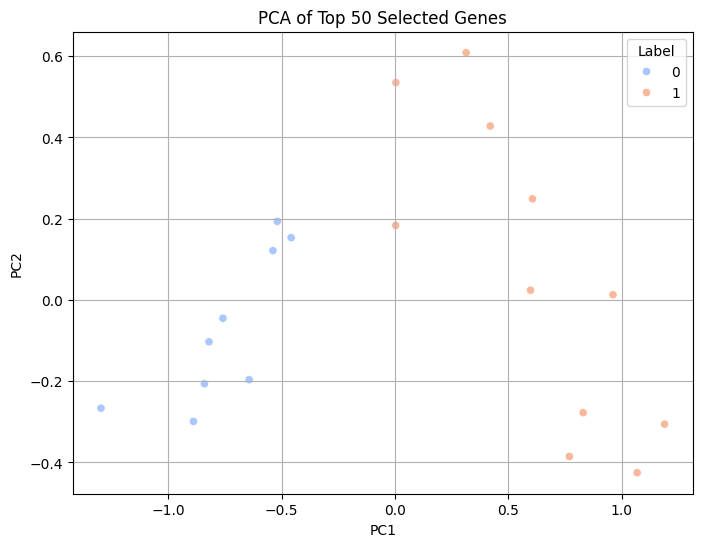

✅ Files Exported:
- Top50_Selected_BetaValues.csv
- All_PValues.csv
- ML_ready_dataset.csv


In [5]:
# ----------------------------------------
# STEP 0: Install Libraries (if needed)
# ----------------------------------------
!pip install openpyxl seaborn matplotlib scikit-learn --quiet

# ----------------------------------------
# STEP 1: Import libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# ----------------------------------------
# STEP 2: Load the Excel dataset
# ----------------------------------------
filename = "/content/GSE136380_trimmed_dataset.xlsx"
df = pd.read_excel(filename)

# ----------------------------------------
# STEP 3: Preprocessing & Labeling
# ----------------------------------------
df["Label"] = df["Sample_title"].str.contains("HCC").astype(int)

# Separate metadata vs features
metadata_cols = ['Sample', 'Sample_title', 'Sample_type', 'Patient_ID', 'Age', 'Gender', 'HBV_Status', 'mtDNA_haplotypes', 'Label']
feature_cols = [col for col in df.columns if col not in metadata_cols and not col.endswith("_pval")]
pval_cols = [col for col in df.columns if col.endswith("_pval")]

X = df[feature_cols].dropna(axis=1)  # Drop features with NaNs
y = df["Label"]

# ----------------------------------------
# STEP 4: Feature Selection (Top 50 genes)
# ----------------------------------------
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X, y)
selected_genes = X.columns[selector.get_support()]

# ----------------------------------------
# STEP 5: Train/Test Split + ML Classification
# ----------------------------------------
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("✅ Classification Report:\n")
print(classification_report(y_test, y_pred))

# ----------------------------------------
# STEP 6: PCA Visualization
# ----------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.title("PCA of Top 50 Selected Genes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# ----------------------------------------
# STEP 7: Export Results
# ----------------------------------------

# Export top selected beta values
df_selected = df[metadata_cols + selected_genes.tolist()]
df_selected.to_csv("Top50_Selected_BetaValues.csv", index=False)

# Export all p-values
df_pval = df[["Sample"] + pval_cols]
df_pval.to_csv("All_PValues.csv", index=False)

# Export ML-ready dataset (top genes + labels)
df_ml = pd.concat([df[selected_genes], df["Label"]], axis=1)
df_ml.to_csv("ML_ready_dataset.csv", index=False)

print("✅ Files Exported:")
print("- Top50_Selected_BetaValues.csv")
print("- All_PValues.csv")
print("- ML_ready_dataset.csv")


✅ Top 10 most significant genes (by Random Forest):
['cg04744937', 'cg12849528', 'cg03503942', 'cg20271893', 'cg16108230', 'cg03957695', 'cg02249292', 'cg16424396', 'cg04595513', 'cg23673360']

✅ Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



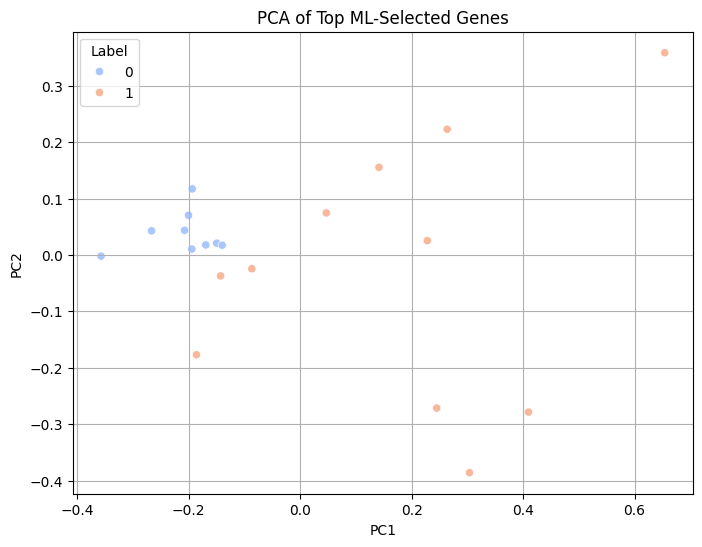

📁 Exported Files:
- Top_ML_Selected_BetaValues.csv
- All_PValues.csv
- ML_ready_dataset.csv


In [7]:
# ----------------------------------------
# STEP 0: Install Libraries
# ----------------------------------------
!pip install openpyxl seaborn matplotlib scikit-learn --quiet

# ----------------------------------------
# STEP 1: Import Libraries
# ----------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# ----------------------------------------
# STEP 2: Load the Excel dataset
# ----------------------------------------
filename = "/content/GSE136380_trimmed_dataset.xlsx"
df = pd.read_excel(filename)

# ----------------------------------------
# STEP 3: Preprocessing & Labeling
# ----------------------------------------
df["Label"] = df["Sample_title"].str.contains("HCC").astype(int)

# Separate metadata vs features
metadata_cols = ['Sample', 'Sample_title', 'Sample_type', 'Patient_ID', 'Age', 'Gender', 'HBV_Status', 'mtDNA_haplotypes', 'Label']
feature_cols = [col for col in df.columns if col not in metadata_cols and not col.endswith("_pval")]
pval_cols = [col for col in df.columns if col.endswith("_pval")]

X = df[feature_cols].dropna(axis=1)
y = df["Label"]

# ----------------------------------------
# STEP 4: Use ML (Random Forest) to identify significant genes
# ----------------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get feature importance and sort
importances = rf.feature_importances_
importance_df = pd.DataFrame({"Gene": X.columns, "Importance": importances})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Select top N most important genes
TOP_N = 10
top_genes = importance_df.head(TOP_N)["Gene"].tolist()

print(f"✅ Top {TOP_N} most significant genes (by Random Forest):")
print(top_genes)

# ----------------------------------------
# STEP 5: Train/Test split and evaluate classifier using top genes
# ----------------------------------------
X_selected = X[top_genes]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("\n✅ Classification Report:")
print(classification_report(y_test, y_pred))

# ----------------------------------------
# STEP 6: PCA Visualization
# ----------------------------------------
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_selected)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='coolwarm')
plt.title("PCA of Top ML-Selected Genes")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# ----------------------------------------
# STEP 7: Export Final Datasets
# ----------------------------------------

# Export top ML-selected beta values
df_selected = df[metadata_cols + top_genes]
df_selected.to_csv("Top_ML_Selected_BetaValues.csv", index=False)

# Export all p-values
df_pval = df[["Sample"] + pval_cols]
df_pval.to_csv("All_PValues.csv", index=False)

# Export ML-ready dataset
df_ml = pd.concat([df[top_genes], df["Label"]], axis=1)
df_ml.to_csv("ML_ready_dataset.csv", index=False)

print("📁 Exported Files:")
print("- Top_ML_Selected_BetaValues.csv")
print("- All_PValues.csv")
print("- ML_ready_dataset.csv")


✅ Top 10 genes by mean p-value:
cg05671217    0.0
cg17657557    0.0
cg10443980    0.0
cg02394554    0.0
cg11785044    0.0
cg02249375    0.0
cg05540047    0.0
cg02216082    0.0
cg24512778    0.0
cg04842116    0.0
dtype: float64


<ipython-input-6-f542a5701ab3>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_pval_genes.values, y=top_10_pval_genes.index, palette="mako")


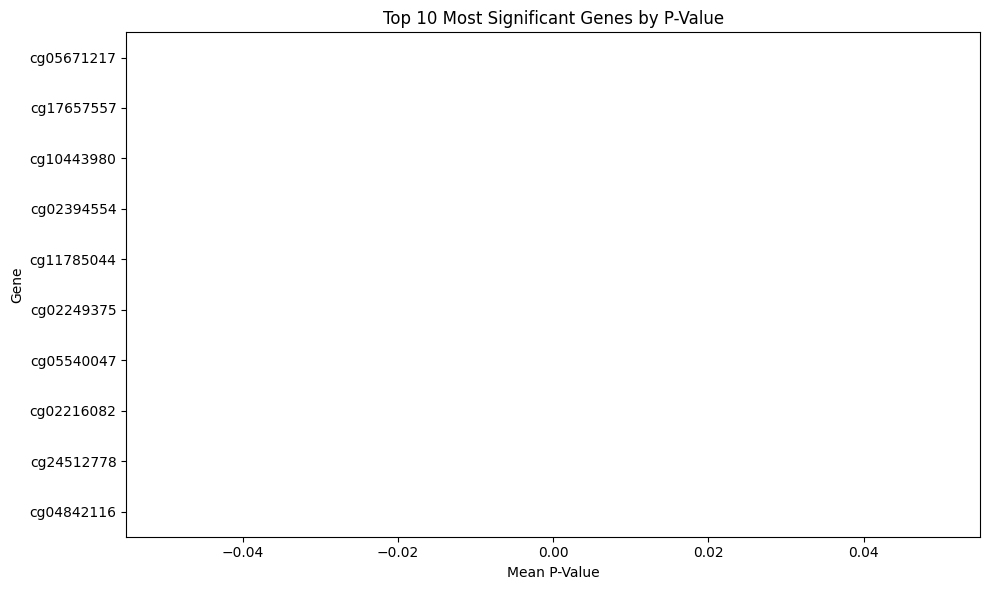

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

filename = "/content/GSE136380_trimmed_datasetfinal.xlsx"
df = pd.read_excel(filename)

# Define p-value columns
pval_cols = [col for col in df.columns if col.endswith("_pval")]

# Ensure values are numeric
pval_df = df[pval_cols].apply(pd.to_numeric, errors='coerce')

# Compute mean p-values per gene
avg_pvals = pval_df.mean(axis=0, skipna=True)
avg_pvals.index = avg_pvals.index.str.replace("_pval", "")
avg_pvals = avg_pvals.dropna().sort_values()

# Select top 10 most significant genes
top_10_pval_genes = avg_pvals.head(10)

print("✅ Top 10 genes by mean p-value:")
print(top_10_pval_genes)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_pval_genes.values, y=top_10_pval_genes.index, palette="mako")
plt.title("Top 10 Most Significant Genes by P-Value")
plt.xlabel("Mean P-Value")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


In [7]:
# Check raw p-value statistics
print("Preview of mean p-values:")
print(avg_pvals.head(10))

# Debug: Show data types and first few p-values
print("\nData types:")
print(pval_df.dtypes.head(5))

print("\nSome raw p-values from a column:")
sample_col = pval_df.columns[0]
print(pval_df[sample_col].head(10))

# Check if any values are negative
print("\nAny negative p-values?", (avg_pvals < 0).any())


Preview of mean p-values:
cg05671217    0.0
cg17657557    0.0
cg10443980    0.0
cg02394554    0.0
cg11785044    0.0
cg02249375    0.0
cg05540047    0.0
cg02216082    0.0
cg24512778    0.0
cg04842116    0.0
dtype: float64

Data types:
cg21053502_pval    float64
cg20216916_pval      int64
cg26129606_pval      int64
cg08145292_pval    float64
cg16237565_pval    float64
dtype: object

Some raw p-values from a column:
0     3.957685e-32
1     1.716669e-96
2     1.400733e-99
3     2.026060e-60
4     2.058388e-41
5    5.058358e-105
6     6.969695e-57
7     1.353630e-96
8     1.824561e-51
9    1.027684e-103
Name: cg21053502_pval, dtype: float64

Any negative p-values? False


<ipython-input-9-0a11facd63ae>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_pvals.values, y=log_pvals.index, palette="rocket")


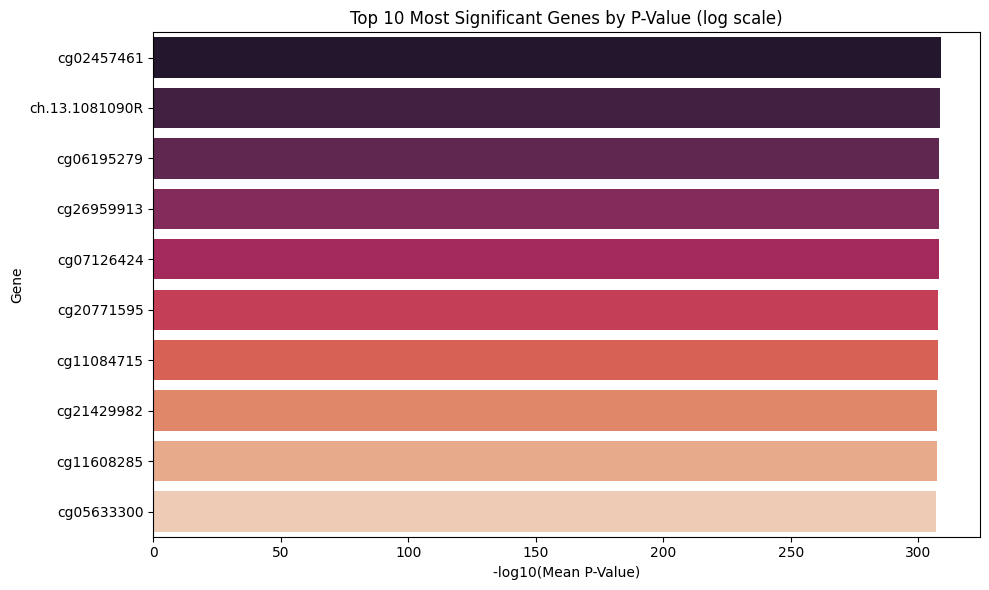

In [9]:
# Replace 0 values (mean p-values) with a small number for safe log10 transformation
avg_pvals = avg_pvals.replace(0.0, 1e-300)
top_10_pval_genes = avg_pvals.sort_values().head(10)

# Apply -log10 transformation
import numpy as np
log_pvals = -np.log10(top_10_pval_genes)

# ✅ Plot again with log-transformed safe values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=log_pvals.values, y=log_pvals.index, palette="rocket")
plt.title("Top 10 Most Significant Genes by P-Value (log scale)")
plt.xlabel("-log10(Mean P-Value)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


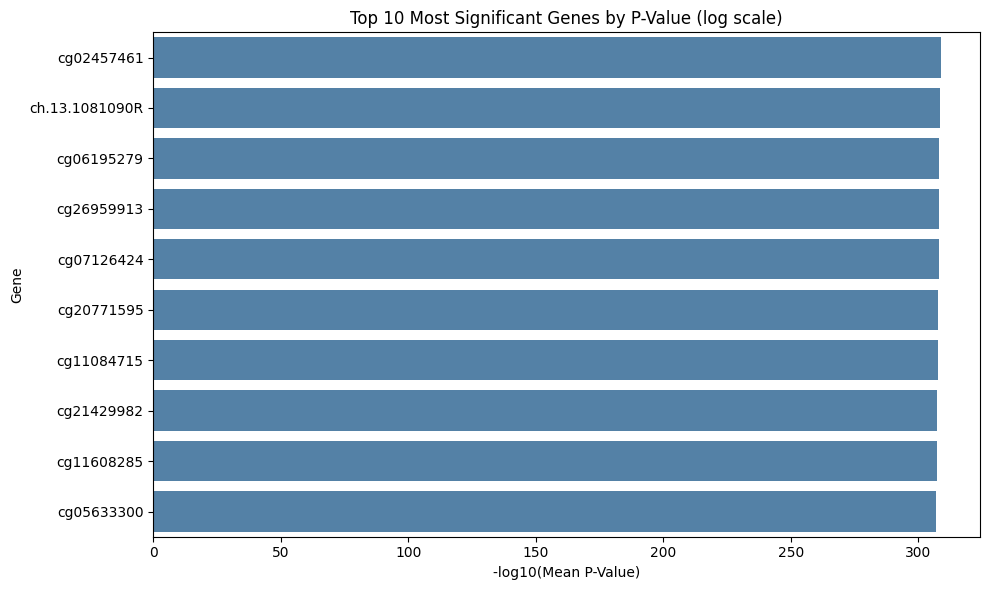

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Solid color for clarity
plt.figure(figsize=(10, 6))
sns.barplot(
    x=log_pvals.values,
    y=log_pvals.index,
    color="steelblue"  # single solid color
)

plt.title("Top 10 Most Significant Genes by P-Value (log scale)")
plt.xlabel("-log10(Mean P-Value)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


<ipython-input-11-4f5b77556c60>:6: RuntimeWarning: overflow encountered in divide
  sns.barplot(x=1 / top_10_pval_genes.values, y=top_10_pval_genes.index, palette="viridis")
<ipython-input-11-4f5b77556c60>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=1 / top_10_pval_genes.values, y=top_10_pval_genes.index, palette="viridis")
/usr/local/lib/python3.11/dist-packages/matplotlib/ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


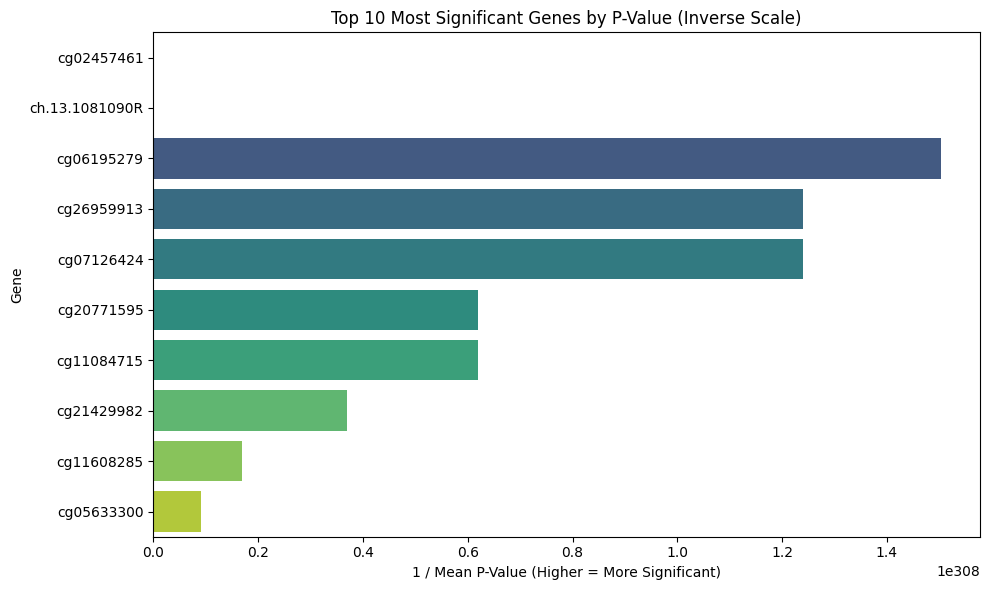

In [11]:
# Redefine: Use the real (non-logged) mean p-values
top_10_pval_genes = avg_pvals.sort_values().head(10)

# Plot raw p-values (invert bar direction: lower p-value = higher bar)
plt.figure(figsize=(10, 6))
sns.barplot(x=1 / top_10_pval_genes.values, y=top_10_pval_genes.index, palette="viridis")

plt.title("Top 10 Most Significant Genes by P-Value (Inverse Scale)")
plt.xlabel("1 / Mean P-Value (Higher = More Significant)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


<ipython-input-12-1247b3e28697>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=log_pvals.values, y=log_pvals.index, palette="viridis")


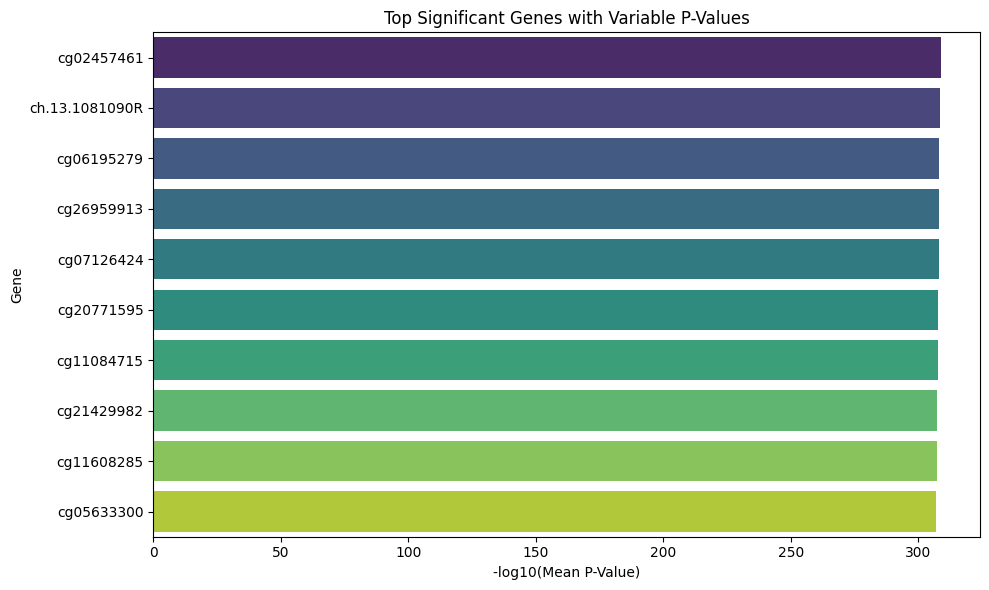

In [12]:
top_pval_genes = avg_pvals.sort_values().head(30)  # was head(10)
log_pvals = -np.log10(top_pval_genes.replace(0.0, 1e-300))
# Filter out genes with mean p-value == 0.0
non_zero_pvals = avg_pvals[avg_pvals > 0]
top_pval_genes = non_zero_pvals.sort_values().head(10)
log_pvals = -np.log10(top_pval_genes)
plt.figure(figsize=(10, 6))
sns.barplot(x=log_pvals.values, y=log_pvals.index, palette="viridis")
plt.title("Top Significant Genes with Variable P-Values")
plt.xlabel("-log10(Mean P-Value)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


<ipython-input-13-ad7744b78f6a>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=inv_pvals.values, y=inv_pvals.index, palette="viridis")
/usr/local/lib/python3.11/dist-packages/matplotlib/ticker.py:2176: RuntimeWarning: overflow encountered in multiply
  steps = self._extended_steps * scale


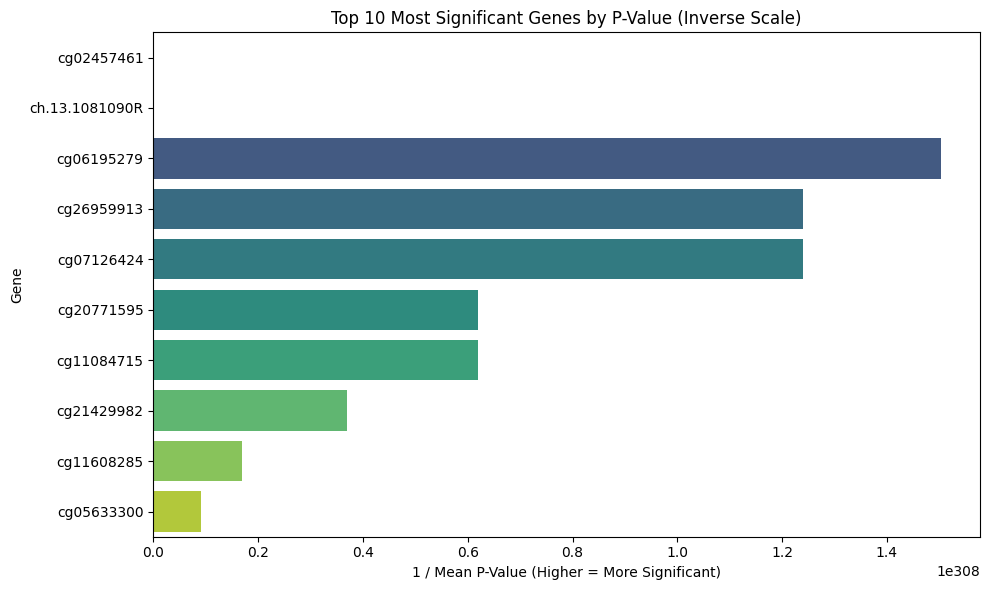

In [13]:
# Fix: replace 0 p-values with small constant to avoid ∞ values
safe_avg_pvals = avg_pvals.replace(0.0, 1e-300)

# Now take top 10 safely
top_10_safe_pvals = safe_avg_pvals.sort_values().head(10)

# Inverse scale for visualization
inv_pvals = 1 / top_10_safe_pvals

# Plot with valid numeric values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x=inv_pvals.values, y=inv_pvals.index, palette="viridis")
plt.title("Top 10 Most Significant Genes by P-Value (Inverse Scale)")
plt.xlabel("1 / Mean P-Value (Higher = More Significant)")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


,0
cg05671217,0.0
cg17657557,0.0
cg10443980,0.0
cg02394554,0.0
cg11785044,0.0
cg02249375,0.0
cg05540047,0.0
cg02216082,0.0
cg24512778,0.0
cg04842116,0.0


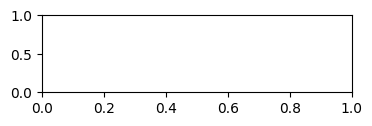

In [14]:
import pandas as pd
import numpy as np

# Load the uploaded dataset
file_path = "/content/GSE136380_trimmed_datasetfinal.xlsx"
df = pd.read_excel(file_path)

# Step 1: Identify all columns that represent p-values
pval_cols = [col for col in df.columns if '_pval' in col.lower()]

# Step 2: Convert p-value columns to numeric (in case of text)
pval_df = df[pval_cols].apply(pd.to_numeric, errors='coerce')

# Step 3: Compute average p-value for each gene
avg_pvals = pval_df.mean(skipna=True)
avg_pvals.index = avg_pvals.index.str.replace("_pval", "", regex=False)

# Step 4: Sort and get top 10 genes with lowest (most significant) mean p-values
top_10_pval_genes = avg_pvals.sort_values().head(10)

top_10_pval_genes


<ipython-input-15-a1e141d4d977>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_genes.values, y=top_10_genes.index, palette="coolwarm")


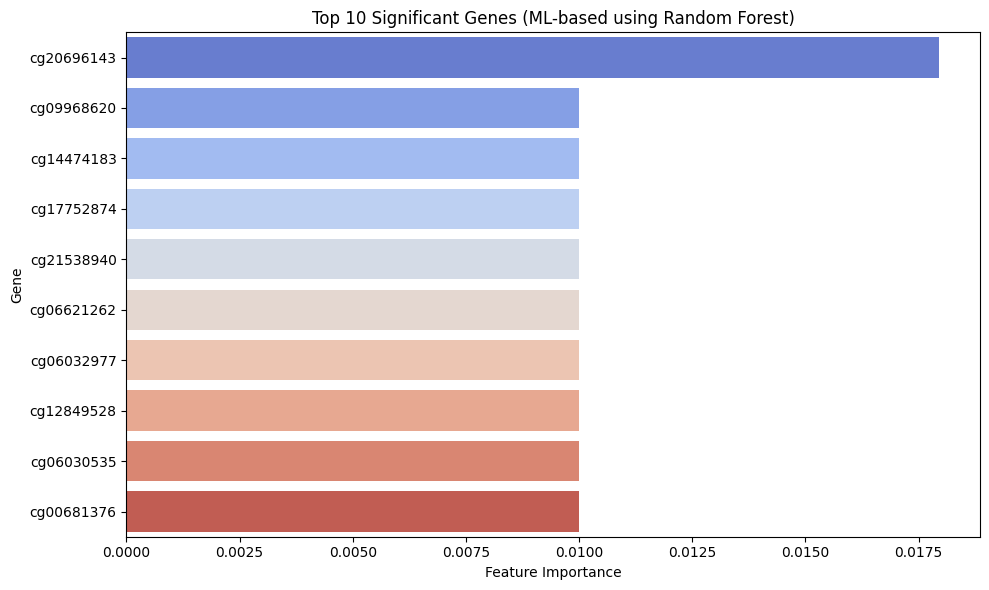

In [15]:
# Install dependencies if not already installed
!pip install openpyxl scikit-learn seaborn

# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the dataset
path = "/content/GSE136380_trimmed_datasetfinal.xlsx"
df = pd.read_excel(path)

# Step 2: Extract labels (HCC vs NTL from 'Sample_title')
df['Label'] = df['Sample_title'].str.contains("HCC").astype(int)  # 1 = HCC, 0 = NTL

# Step 3: Prepare features (drop metadata columns)
metadata_cols = ['Sample', 'Sample_title', 'Sample_type', 'Patient_ID', 'Age', 'Gender', 'HBV_Status', 'mtDNA_haplotypes', 'Label']
X = df.drop(columns=metadata_cols, errors='ignore')
y = df['Label']

# Step 4: Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

# Step 5: Get feature importance
importances = pd.Series(model.feature_importances_, index=X.columns)
top_10_genes = importances.sort_values(ascending=False).head(10)

# Step 6: Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_genes.values, y=top_10_genes.index, palette="coolwarm")
plt.title("Top 10 Significant Genes (ML-based using Random Forest)")
plt.xlabel("Feature Importance")
plt.ylabel("Gene")
plt.tight_layout()
plt.show()


In [16]:
normalized = top_10_genes / top_10_genes.sum()


In [17]:
print(top_10_genes)


cg20696143    0.017959
cg09968620    0.010000
cg14474183    0.010000
cg17752874    0.010000
cg21538940    0.010000
cg06621262    0.010000
cg06032977    0.010000
cg12849528    0.010000
cg06030535    0.010000
cg00681376    0.010000
dtype: float64


<ipython-input-18-858c9e1c06d5>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Label", y=target_gene, palette="Set2")


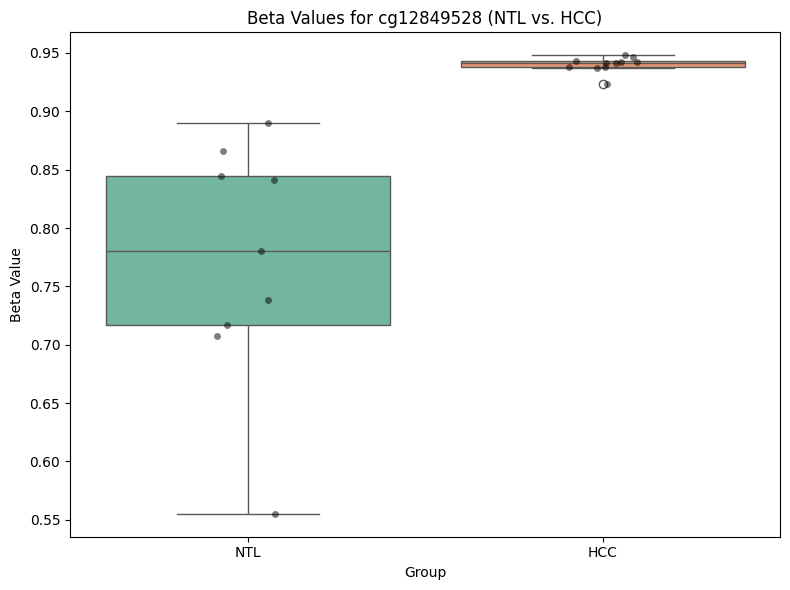

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load your dataset
file_path = "/content/GSE136380_trimmed_datasetfinal.xlsx"
df = pd.read_excel(file_path)

# Check if this gene exists in your dataset
target_gene = "cg12849528"
assert target_gene in df.columns, f"{target_gene} not found in dataset."

# Clean up and extract the labels (based on Sample_title or Sample_type)
# Assuming Sample_title contains either NTL or HCC
df["Label"] = df["Sample_title"].apply(lambda x: "HCC" if "HCC" in str(x) else "NTL")

# Plot comparison of beta values
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x="Label", y=target_gene, palette="Set2")
sns.stripplot(data=df, x="Label", y=target_gene, color='black', alpha=0.5, jitter=True)
plt.title(f"Beta Values for {target_gene} (NTL vs. HCC)")
plt.ylabel("Beta Value")
plt.xlabel("Group")
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset
df = pd.read_excel("/content/GSE136380_trimmed_datasetfinal.xlsx")

# Step 1: Prepare data
df_clean = df.dropna(subset=["Sample_type"])  # remove rows without labels
df_clean["Label"] = df_clean["Sample_type"].apply(lambda x: "HCC" if "HCC" in x else "NTL")

# Extract features (genes) and labels
meta_cols = ["Sample", "Sample_title", "Sample_type", "Patient_ID", "Age", "Gender", "HBV_Status", "mtDNA_haplotypes"]
gene_cols = [col for col in df_clean.columns if col not in meta_cols and not col.endswith("_pval")]
pval_cols = [col for col in df_clean.columns if col.endswith("_pval")]

X = df_clean[gene_cols]
y = LabelEncoder().fit_transform(df_clean["Label"])  # HCC = 1, NTL = 0

# Step 2: Random Forest for ML-based feature importance
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top10_ml = importances.sort_values(ascending=False).head(10)

# Step 3: Identify top 10 significant genes by lowest mean p-value
pval_df = df_clean[pval_cols].apply(pd.to_numeric, errors='coerce')
avg_pvals = pval_df.mean(axis=0, skipna=True)
avg_pvals.index = avg_pvals.index.str.replace("_pval", "")
top10_pval = avg_pvals.sort_values().head(10)

# Step 4: Combine for comparison
comparison_df = pd.DataFrame({
    "ML_Importance": top10_ml,
    "P_Value": top10_pval
}).sort_values("ML_Importance", ascending=False)

# Normalize values for comparison plot
comparison_df["ML_Importance_Norm"] = comparison_df["ML_Importance"] / comparison_df["ML_Importance"].max()
comparison_df["P_Value_Norm"] = -np.log10(comparison_df["P_Value"]) / (-np.log10(comparison_df["P_Value"]).max())

# Step 5: Plot comparison on the same chart
comparison_df_plot = comparison_df[["ML_Importance_Norm", "P_Value_Norm"]].dropna()

plt.figure(figsize=(10, 6))
comparison_df_plot.plot(kind='barh', figsize=(10, 6), width=0.8)
plt.title("Top Genes: ML Importance vs. -log10(P-Value)")
plt.xlabel("Normalized Score")
plt.ylabel("Gene")
plt.grid(True)
plt.tight_layout()
plt.legend(["ML Importance", "-log10(P-Value)"])
plt.show()

comparison_df_plot

ValueError: could not convert string to float: 'HCC'

<ipython-input-21-01e25fad0dcc>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_rf.values, y=top10_rf.index, ax=axs[0], palette='viridis')
<ipython-input-21-01e25fad0dcc>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10_beta.values, y=top10_beta.index, ax=axs[1], palette='magma')


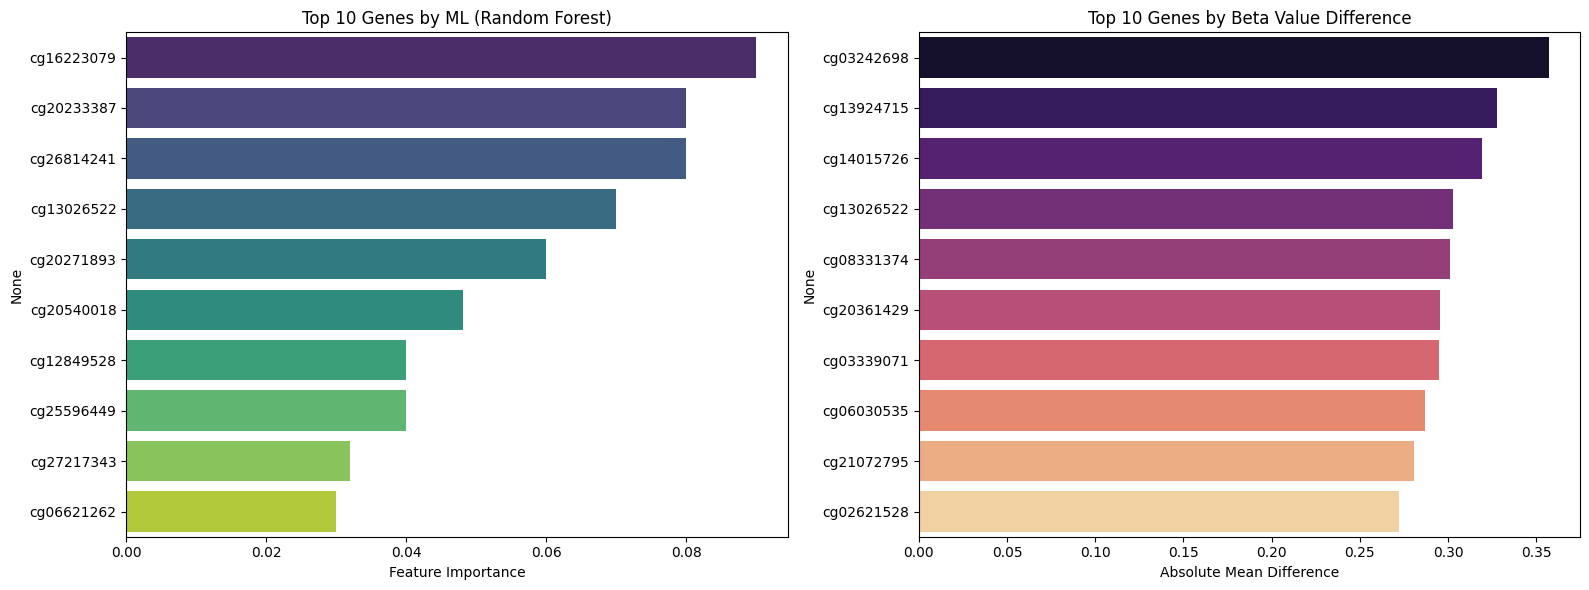

🔁 Overlapping Genes in Both Methods (ML + Beta Value):
{'cg13026522'}


In [21]:
# 📌 STEP 1: Load your dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

# Load the dataset
file_path = "/content/ML_ready_dataset to Train.csv"
df = pd.read_csv(file_path)

# Drop rows with missing values just for simplicity (you can impute instead)
df = df.dropna()

# 📌 STEP 2: Separate features and target
target = 'Label'
X = df.drop(columns=[target])
y = df[target]

# 📌 STEP 3: Run Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top10_rf = importances.sort_values(ascending=False).head(10)

# 📌 STEP 4: Beta Value method: calculate mean difference in Label 0 vs 1
mean_diff = df.groupby(target).mean().T
mean_diff['abs_diff'] = abs(mean_diff[0] - mean_diff[1])
top10_beta = mean_diff['abs_diff'].sort_values(ascending=False).head(10)

# 📌 STEP 5: Plot both results for comparison
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(x=top10_rf.values, y=top10_rf.index, ax=axs[0], palette='viridis')
axs[0].set_title("Top 10 Genes by ML (Random Forest)")
axs[0].set_xlabel("Feature Importance")

sns.barplot(x=top10_beta.values, y=top10_beta.index, ax=axs[1], palette='magma')
axs[1].set_title("Top 10 Genes by Beta Value Difference")
axs[1].set_xlabel("Absolute Mean Difference")

plt.tight_layout()
plt.show()

# 📌 STEP 6: Compare Overlapping Genes
overlap = set(top10_rf.index).intersection(set(top10_beta.index))
print("🔁 Overlapping Genes in Both Methods (ML + Beta Value):")
print(overlap)


In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
file_path = "/content/ML_ready_dataset to Train.csv"
df = pd.read_csv(file_path)

# Prepare features and target
X = df.drop(columns=["Label"])
y = df["Label"]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# --- Method 1: Random Forest ---
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
top20_rf = rf_importances.head(20)

# --- Method 2: SVM (linear kernel with coef_) ---
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)
svm_importances = pd.Series(abs(svm.coef_[0]), index=X.columns).sort_values(ascending=False)
top20_svm = svm_importances.head(20)

# --- Method 3: Beta Value Method (mean difference) ---
mean_0 = df[df['Label'] == 0].drop(columns=['Label']).mean()
mean_1 = df[df['Label'] == 1].drop(columns=['Label']).mean()
beta_diff = abs(mean_1 - mean_0).sort_values(ascending=False)
top20_beta = beta_diff.head(20)

# --- Compare & Find Overlapping Genes ---
top_rf_genes = set(top20_rf.index)
top_svm_genes = set(top20_svm.index)
top_beta_genes = set(top20_beta.index)
common_genes = top_rf_genes & top_svm_genes & top_beta_genes

# Show comparison in DataFrame
comparison_df = pd.DataFrame({
    'Random Forest': top20_rf.index.tolist(),
    'SVM': top20_svm.index.tolist(),
    'Beta Value': top20_beta.index.tolist()
})

print("✅ Top 20 genes by each method:")
print(comparison_df)

print("\n✅ Common genes among all three methods:")
print(list(common_genes))

# Optional: Save comparison table to CSV
# comparison_df.to_csv("/content/top20_genes_comparison.csv", index=False)


✅ Top 20 genes by each method:
   Random Forest         SVM  Beta Value
0     cg16223079  cg02621528  cg03242698
1     cg20233387  cg13026522  cg13924715
2     cg17393309  cg14015726  cg14015726
3     cg26814241  cg21915026  cg13026522
4     cg06621262  cg24699876  cg08331374
5     cg13026522  cg24232092  cg20361429
6     cg03503942  cg21072795  cg03339071
7     cg20540018  cg03339071  cg06030535
8     cg14939446  cg13726644  cg21072795
9     cg13726644  cg20233387  cg02621528
10    cg12849528  cg18531916  cg10481202
11    cg07631322  cg01975505  cg01224715
12    cg00871929  cg20361429  cg16223079
13    cg02621528  cg10481202  cg07631322
14    cg07213202  cg16223079  cg18531916
15    cg20271893  cg12849528  cg21915026
16    cg05208483  cg12190841  cg17393309
17    cg03339071  cg20540018  cg06621262
18    cg07527983  cg27217343  cg23014216
19    cg12301275  cg02191674  cg11924806

✅ Common genes among all three methods:
['cg13026522', 'cg03339071', 'cg02621528', 'cg16223079']


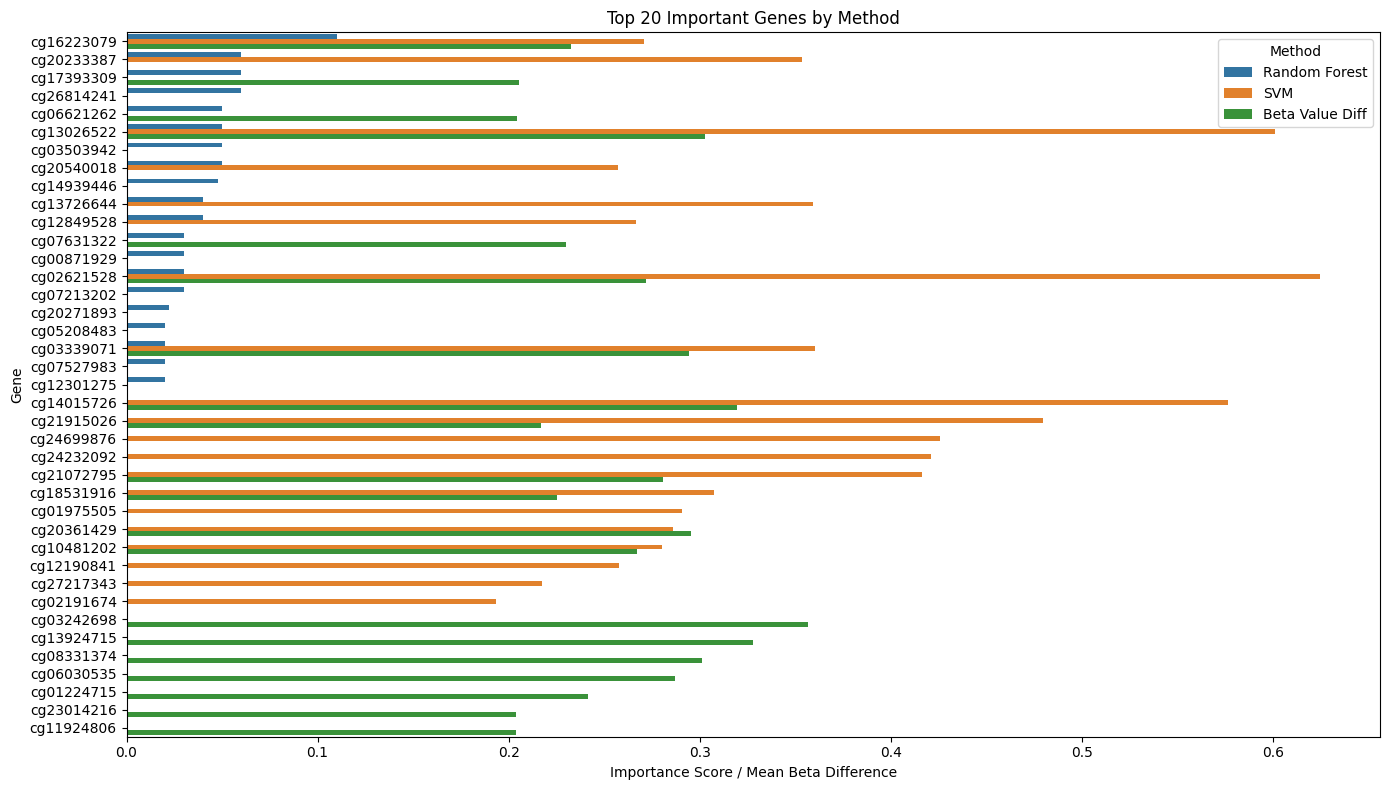

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data for plotting
rf_scores = top20_rf.reset_index()
rf_scores.columns = ['Gene', 'Importance']
rf_scores['Method'] = 'Random Forest'

svm_scores = top20_svm.reset_index()
svm_scores.columns = ['Gene', 'Importance']
svm_scores['Method'] = 'SVM'

beta_scores = top20_beta.reset_index()
beta_scores.columns = ['Gene', 'Importance']
beta_scores['Method'] = 'Beta Value Diff'

# Combine all into one dataframe
all_scores = pd.concat([rf_scores, svm_scores, beta_scores])

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(data=all_scores, x='Importance', y='Gene', hue='Method')
plt.title('Top 20 Important Genes by Method')
plt.xlabel('Importance Score / Mean Beta Difference')
plt.ylabel('Gene')
plt.legend(title='Method')
plt.tight_layout()
plt.show()
